In [45]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM #CuDNNLSTM
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import TensorBoard
import time

NAME = "DDoS_LSTM_RNN{}".format(int(time.time()))
tensorboard = TensorBoard(log_dir = 'C:\\logs\\{}'.format(NAME))


In [46]:
df = pd.read_csv('./KDDTrain.csv')
df_val = pd.read_csv('./KDDTest.csv')


In [47]:
num_feat = ['src_bytes','dst_bytes','wrong_fragment','urgent','hot','num_failed_logins','num_compromised','root_shell','su_attempted','num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate']


In [48]:
# feature_df = df
# X = np.asarray(feature_df)
# y = np.asarray(df['class'])


In [49]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, stratify = y)


In [50]:
#Change features with object or string value into numeric numbers
ord_feat = ['protocol_type', 'service', 'flag']
#Nom_feat = column value with 0 or 1
nom_feat = ['land', 'logged_in', 'is_host_login', 'is_guest_login']
num_feat = ['src_bytes','dst_bytes','wrong_fragment','urgent','hot','num_failed_logins','num_compromised','root_shell','su_attempted','num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate']

X_train, y_train = df.drop(columns=['class'], axis=1, inplace=False), df['class'].values


ohe = OneHotEncoder(sparse=False)
oe = OrdinalEncoder()

ohe.fit(X_train[nom_feat].values)
oe.fit(X_train[ord_feat].values)


scalar = StandardScaler()
scalar.fit(X_train[num_feat].values)
X_train_nom = ohe.transform(X_train[nom_feat].values)
X_train_ord = oe.transform(X_train[ord_feat].values)
X_train_num = scalar.transform(X_train[num_feat].values)

X_train = np.concatenate([X_train_ord, X_train_num, X_train_nom], axis=1)
print(X_train.shape)
#reshape Train dataset into 3d array
X_train = X_train.reshape((X_train.shape[0],1,X_train.shape[1]))
y_train = y_train.reshape((y_train.shape[0],1,1))

#Scale the num, ord, nom datasets
X_test, y_test = df_val.drop(columns=['class'], axis = 1, inplace=False), df_val['class'].values

ohe.fit(X_test[nom_feat].values)
oe.fit(X_test[ord_feat].values)
#reshape Test dataset into 3d array

scalar.fit(X_test[num_feat].values)
X_test_nom = ohe.transform(X_test[nom_feat].values)
X_test_ord = oe.transform(X_test[ord_feat].values)
X_test_num = scalar.transform(X_test[num_feat].values)
X_test = np.concatenate([X_test_ord, X_test_num, X_test_nom], axis=1)
X_test.shape
X_test = X_test.reshape((X_test.shape[0],1,X_test.shape[1]))
y_test = y_test.reshape((y_test.shape[0],1,1))
print(X_test.shape)


(125973, 44)
(52977, 1, 44)


In [51]:
model = Sequential()
#50 time steps, and 2 features
#LSTM INOUT (Batch size, Time steps, units)
model.add(LSTM(units = 44, input_shape=(1,44), return_sequences=True))
model.add(Dense(1))
model.add(Dense(1))
model.compile(loss="mean_absolute_error", optimizer = 'adam', metrics = ["accuracy"])
# model.summary()

history = model.fit(X_train, y_train, epochs=30, validation_data = (X_test, y_test), callbacks = [tensorboard])# validation_data=(X_test, y_test)

Train on 125973 samples, validate on 52977 samples
Epoch 1/30
125973/125973 [==============================] - 20s 160us/sample - loss: 0.0534 - accuracy: 0.9611 - val_loss: 0.0384 - val_accuracy: 0.9696
Epoch 2/30
125973/125973 [==============================] - 18s 139us/sample - loss: 0.0351 - accuracy: 0.9727 - val_loss: 0.0303 - val_accuracy: 0.9775
Epoch 3/30
125973/125973 [==============================] - 17s 137us/sample - loss: 0.0287 - accuracy: 0.9830 - val_loss: 0.0257 - val_accuracy: 0.9875
Epoch 4/30
125973/125973 [==============================] - 17s 137us/sample - loss: 0.0239 - accuracy: 0.9879 - val_loss: 0.0231 - val_accuracy: 0.9896
Epoch 5/30
125973/125973 [==============================] - 17s 137us/sample - loss: 0.0217 - accuracy: 0.9892 - val_loss: 0.0237 - val_accuracy: 0.9892
Epoch 6/30
125973/125973 [==============================] - 17s 138us/sample - loss: 0.0201 - accuracy: 0.9898 - val_loss: 0.0209 - val_accuracy: 0.9902
Epoch 7/30
125973/125973 [=====

In [52]:
val_loss, val_acc = model.evaluate(X_test, y_test)
print(val_loss, val_acc)

52977/52977 [==============================] - 2s 46us/sample - loss: 0.0111 - accuracy: 0.9932
0.011124639040081947 0.9932046


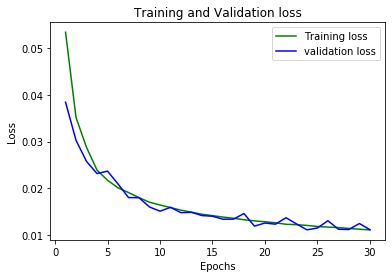

In [53]:
#Visualization of the Loss

loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,31)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

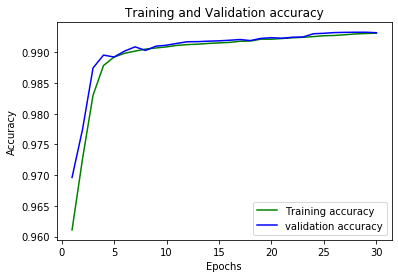

In [54]:
#Visualization of the accuracy.

loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,31)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()